In [401]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  normalize

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [363]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')

data
# labels = data['quality']
# data = data.drop(columns='quality',errors = 'ignore')
# labels = torch.tensor(labels.values).float()     # labels  можно и так так как это сериас
# data = torch.tensor(data.values).float()         # data.values можно только и только лишь так в ином случие нельзя будет ошибка
data['quality'] = data['quality'].apply(lambda x : 1 if x >5 else 0)
lables = data['quality']
data = data.drop(columns = 'quality')
data = pd.DataFrame(stats.zscore(data),columns = data.columns)
labels = torch.tensor(lables.values).float()
data = torch.tensor(data.values, ).float()


In [415]:
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data =  TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
train_batchsize = 16
test_batchsize  = test_data.tensors[0].shape[0]
train_loader = DataLoader(train_data,batch_size=train_batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_batchsize)

In [416]:
class theModelClass(nn.Module):
  def __init__(self):
    super().__init__()

    ### layers
    self.input  = nn.Linear(  11,128)
    self.hidden = nn.Linear(128,64)
    self.hidden2 = nn.Linear(64,16)
    self.output = nn.Linear(16, 1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.hidden(x) )
    x = F.relu( self.hidden2(x) )
    return self.output(x)

In [417]:

def createANewModel():

  # grab an instance of the model class
  ANNQC = theModelClass()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=0.01,weight_decay=0.001)

  return ANNQC,lossfun,optimizer

In [418]:
# train the model

# global parameter
numepochs = 100

# NOTE: this time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC,lossfun,optimizer):

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []
  de = []
  yy = []
  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:
      ANNQC.train()
      # forward pass and loss
      yHat = ANNQC(X).squeeze()
      loss = lossfun(yHat,y)
      # print(yHat)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy (NOTE: testing in batches!)
    tstacc = []
    ANNQC.eval()
    for X,y in test_loader:
      yHat = ANNQC(X).squeeze()
      tstacc.append( 100*torch.mean(((yHat>0)==y).float()).item()	)

    # now get the average accuracy over test-batches
    testAcc.append(np.mean(tstacc))

  # function output
  return trainAcc,testAcc


In [419]:
# create a model
ANNQC,lossfun,optimizer = createANewModel()

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)


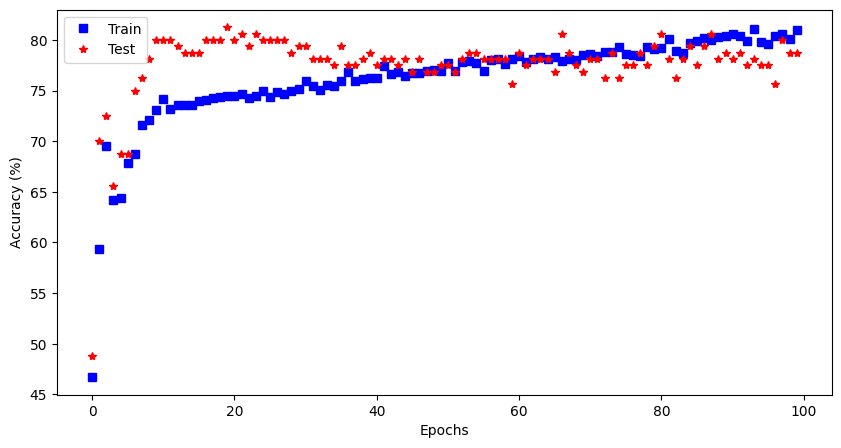

In [420]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs')
plt.plot(testAcc,'r*')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

plt.show()

In [422]:
from typing import final
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)
bìches = [2,8,32,128,512]
final_acc_tr = np.zeros((numepochs,len(bìches)))
final_acc_ts = np.zeros((numepochs,len(bìches)))

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data =  TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)
start = time.time()
sterter = np.zeros(len(bìches))

# finally, translate into dataloader objects
for i in range(len(bìches)):
  starttime = time.process_time()
  test_batchsize  = test_data.tensors[0].shape[0]

  train_loader = DataLoader(train_data,batch_size=bìches[i],shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=bìches[i])

  # create a model
  ANNQC,lossfun,optimizer = createANewModel()
  # train the model (note the inputs!)
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)
  final_acc_tr[:,i] = trainAcc
  final_acc_ts[:,i] = testAcc


  sterter[i] = time.process_time() - starttime

In [423]:
len(trainAcc)

100

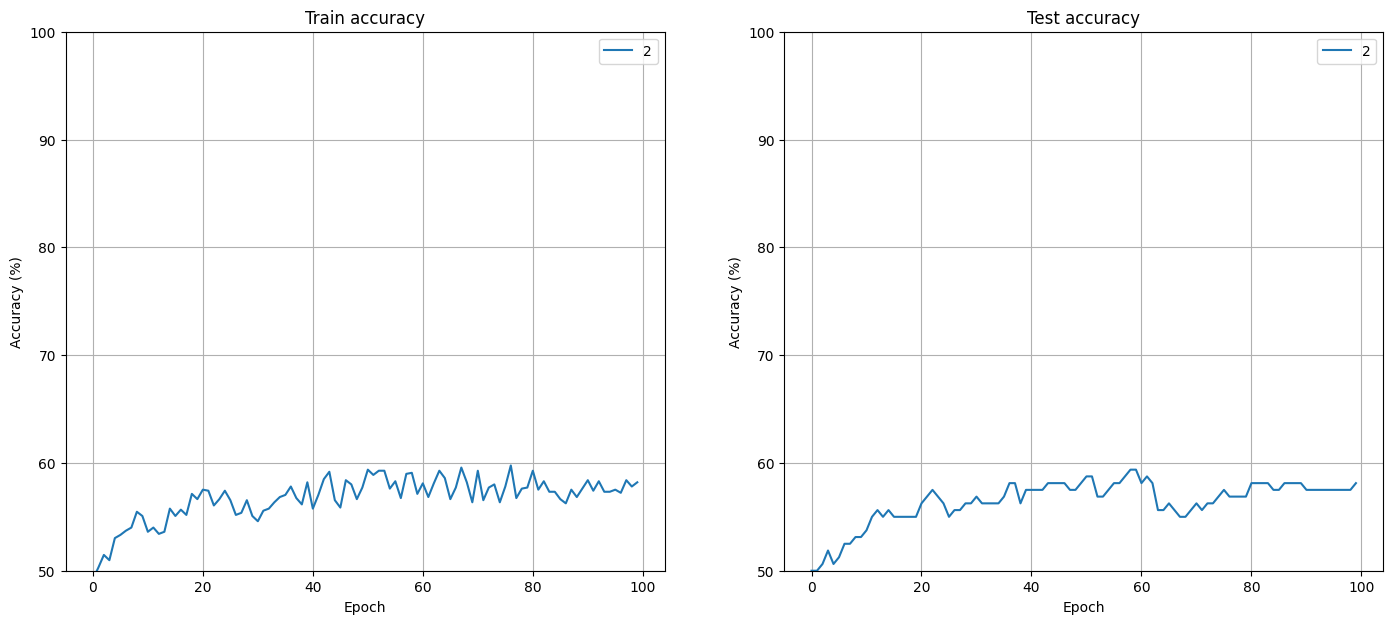

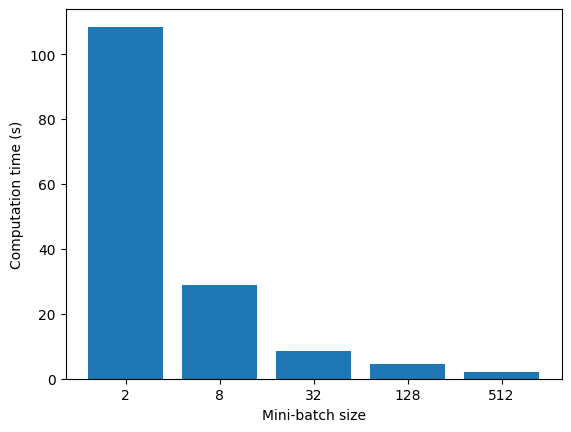

In [424]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(trainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(testAcc)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(bìches)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()



# bar plot of computation time
plt.bar(range(len(sterter)),sterter,tick_label=bìches)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()